In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(mclust)
library(cowplot)
library(tidyverse)
library(reshape)
library(SingleR)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(patchwork)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
      plot.title = element_text(size = 10),
    text = element_text(size = 10, colour = "black"),
    legend.text = element_text(size = 10),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: 'DT'


The following object is masked from 'package:SeuratObject':

    JS


The following object is masked from 'package:Seurat':

    JS



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


here() starts at /auto/brno2/home/vercanie/DIA

Package 'mclust' version 5.4.8
Type 'citation("mclust")' for citing this R package in publica

### Read datasets

In [2]:
plan("multisession")

In [ ]:
cd4_full_filt  <- readRDS("data/processed/cd4_full_filt.rds")
cd4_subcluster  <- readRDS("data/processed/cd4_subcluster.rds")
teff  <- readRDS("data/processed/cd4_teff_subcluster.rds")

In [3]:
treg  <- readRDS("data/processed/treg_subcluster.rds")

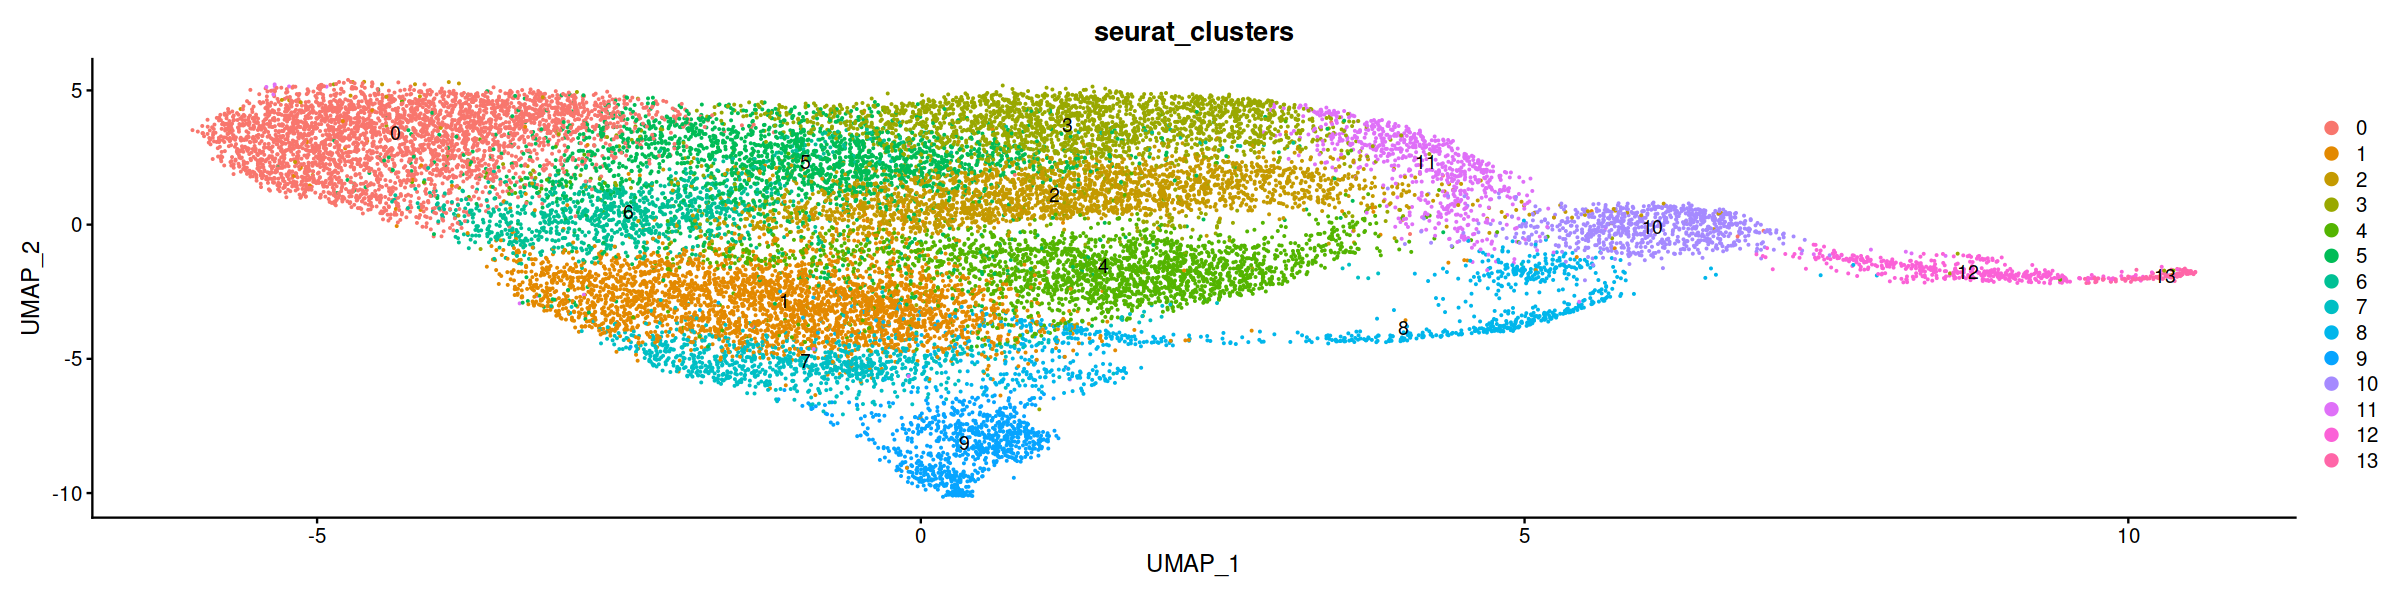

In [43]:
DimPlot(teff, group.by = "seurat_clusters", label = T)

In [39]:
teff  <- FindNeighbors(teff)
teff  <- FindClusters(teff, resolution = 0.9)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21835
Number of edges: 643022

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8034
Number of communities: 14
Elapsed time: 3 seconds


In [40]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- teff@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, seurat_clusters) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "seurat_clusters", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "seurat_clusters")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~seurat_clusters, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


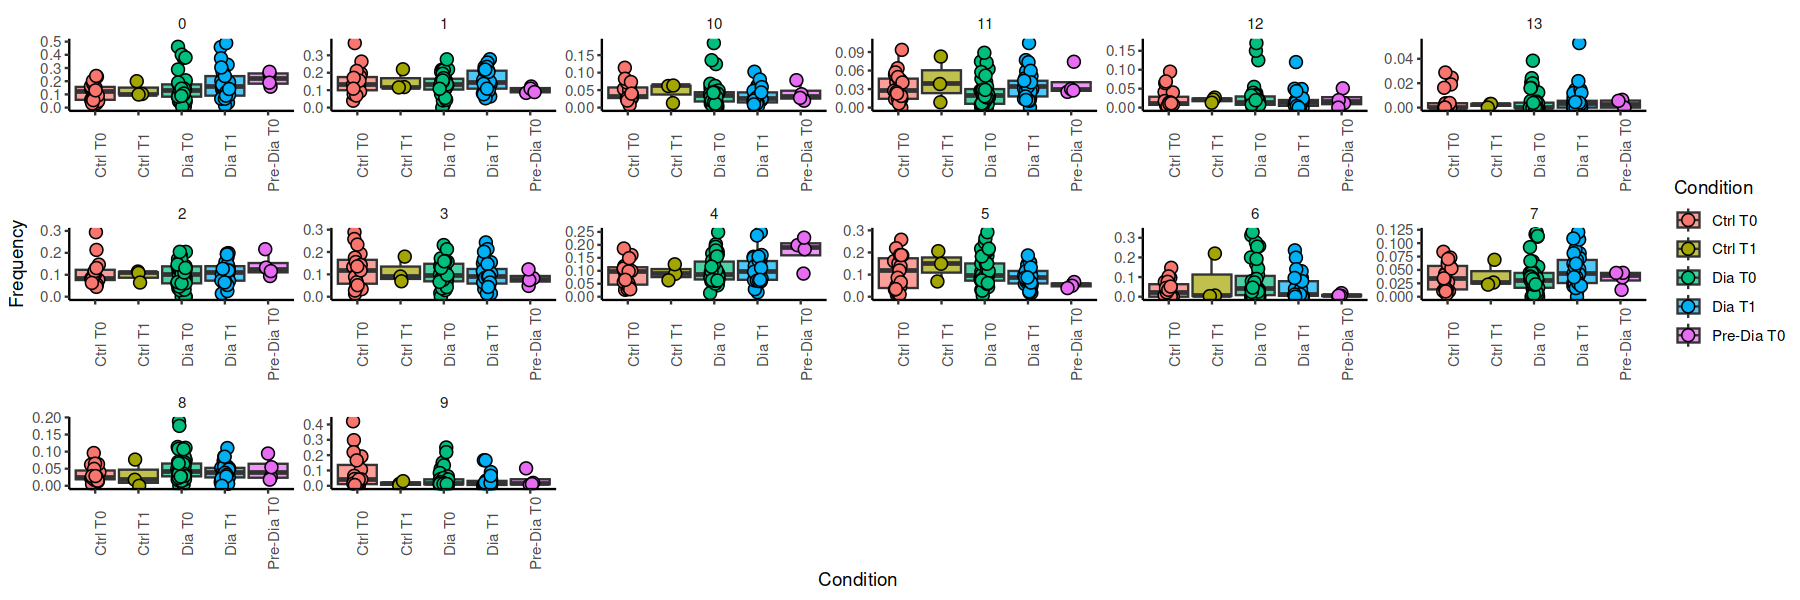

In [41]:
p0

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


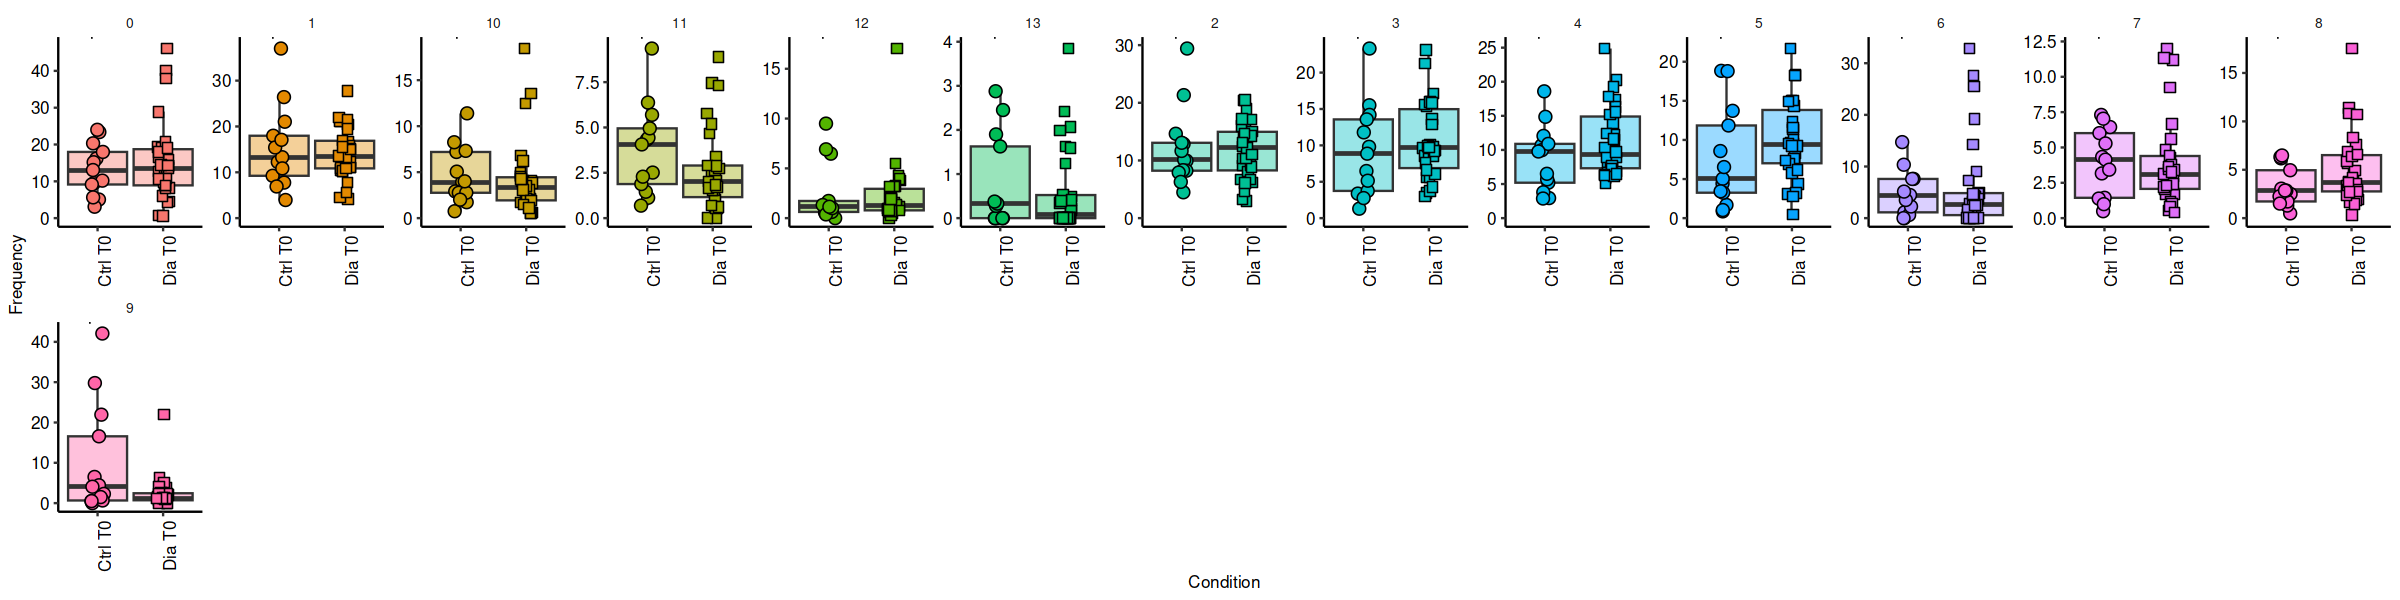

In [42]:
options(repr.plot.width = 20, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = seurat_clusters)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = seurat_clusters, shape = Condition), color = "black") + 
  facet_wrap(~seurat_clusters, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


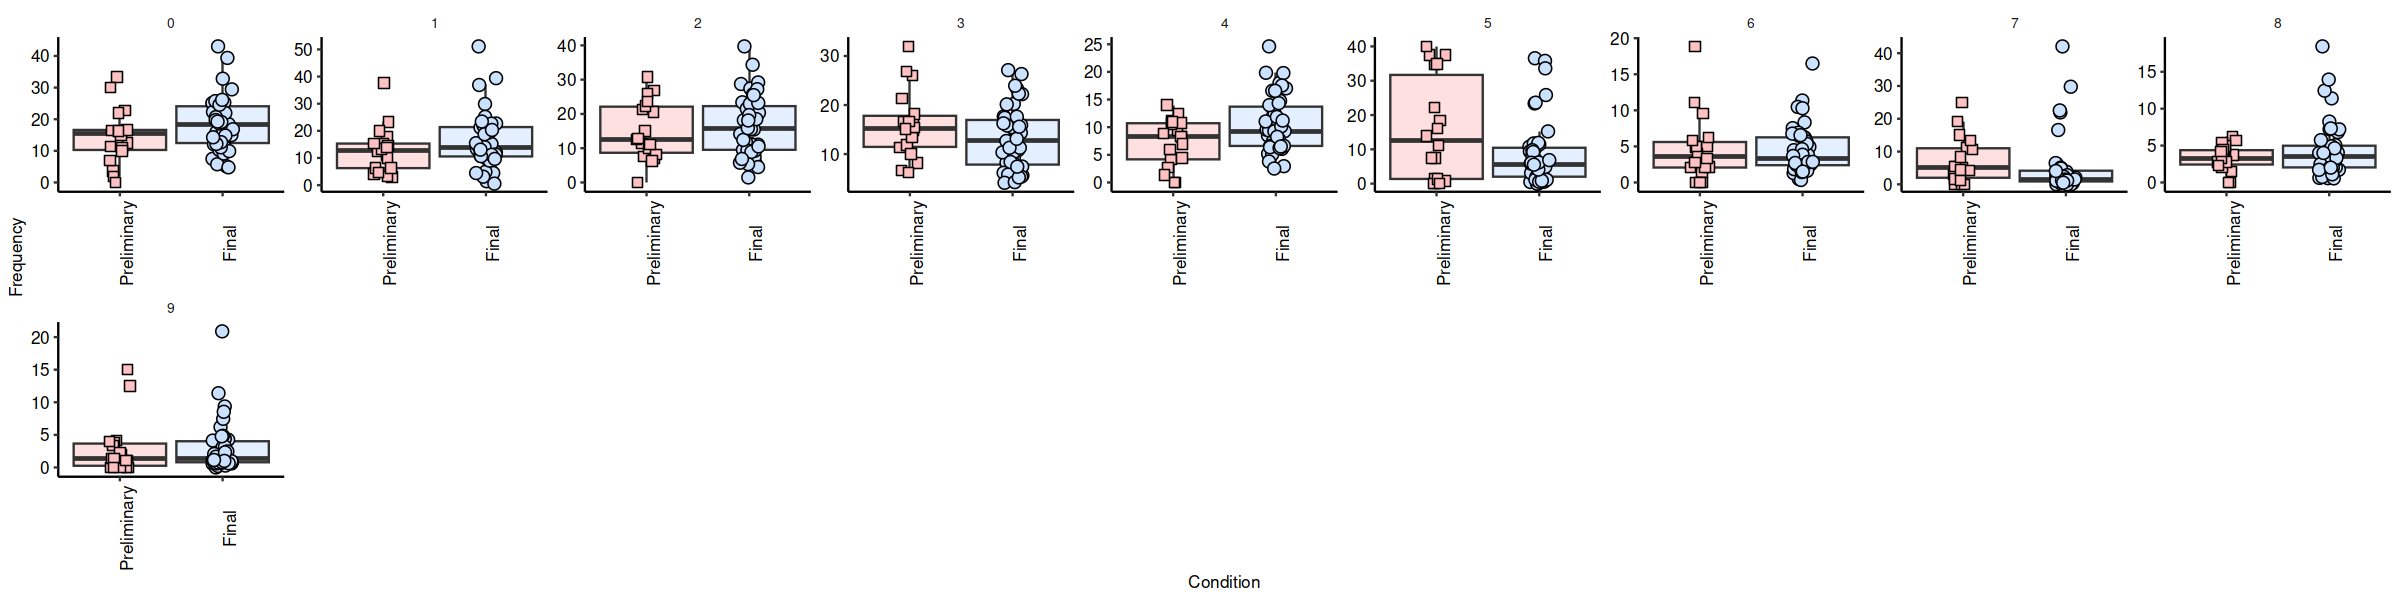

In [38]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~seurat_clusters, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 5)

seurat_meta_data %>% 
  group_by(Sample_ID, seurat_clusters) %>% 
  summarise(n = n()) %>% 
  unique()  %>% 
ungroup   %>% 
pivot_wider(names_from = "seurat_clusters", names_prefix = "Cluster", values_from = "n", values_fill = 0)    %>% 
mutate(ratio = ifelse(Cluster0==0,Cluster1/0.1,Cluster0/Cluster1))  %>% dplyr::select(Sample_ID, ratio)  %>% 
left_join(dplyr::select(df4, -freq, -seurat_clusters))  %>% unique()  %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0")) %>% 

ggplot(aes(x = Condition, y = ratio)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
   ylab("Ratio") +
  xlab("") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 0.9, label.y.npc = 1, size = 7.025, vjust = 0.3, label = "p.format") +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90)) + ggtitle("Th1/Th2 ratio") + NoLegend() + 
ggtheme() + theme(title = element_text(size = 16))

# Full dataset

## Cluster composition

In [4]:
cd4_full_filt@misc$  <- c("slategrey","#44918b",  "grey77")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



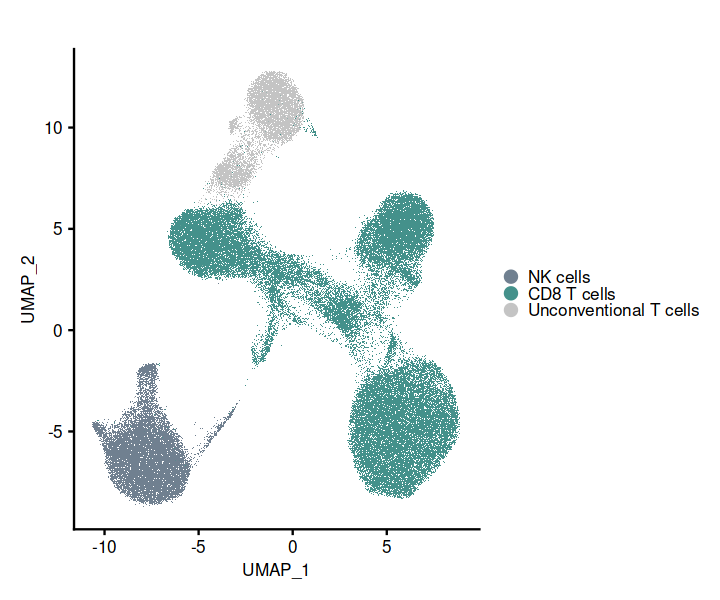

In [5]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd4_full_filt, label = F, raster = T, group.by = "annotations_l1",
       cols = cd4_full_filt@misc$colors_annotations_l1) + ggtheme() + ggtitle("")
dimplot1

In [6]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd4_full_filt@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l1) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l1", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l1")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


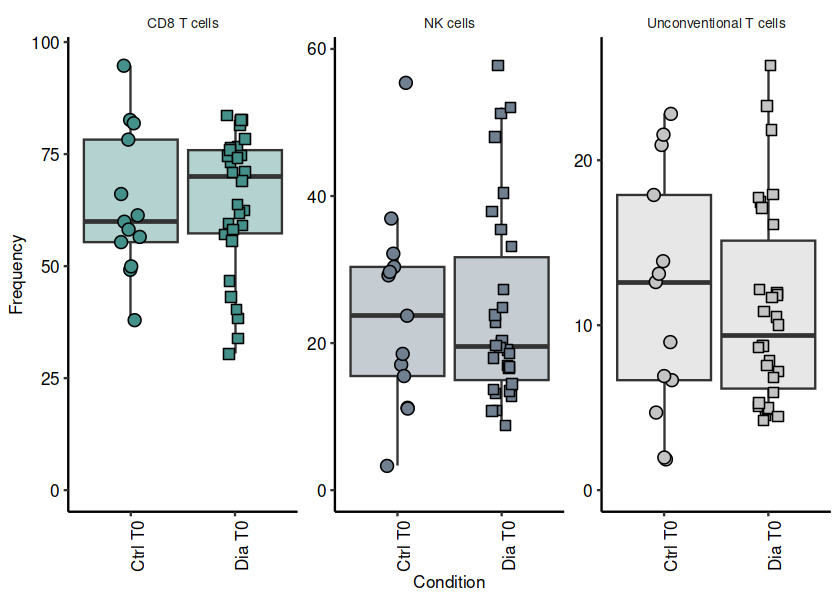

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l1)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l1, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("#44918b", "slategrey", "grey77"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


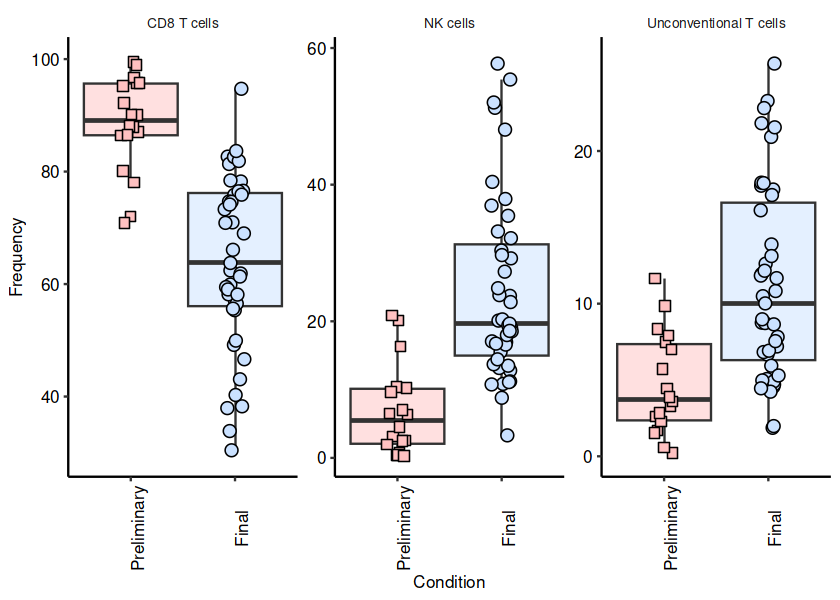

In [8]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

### Save freqencies

In [52]:
layout <- "
AA##
AA##
BBBB
CCCC
"

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


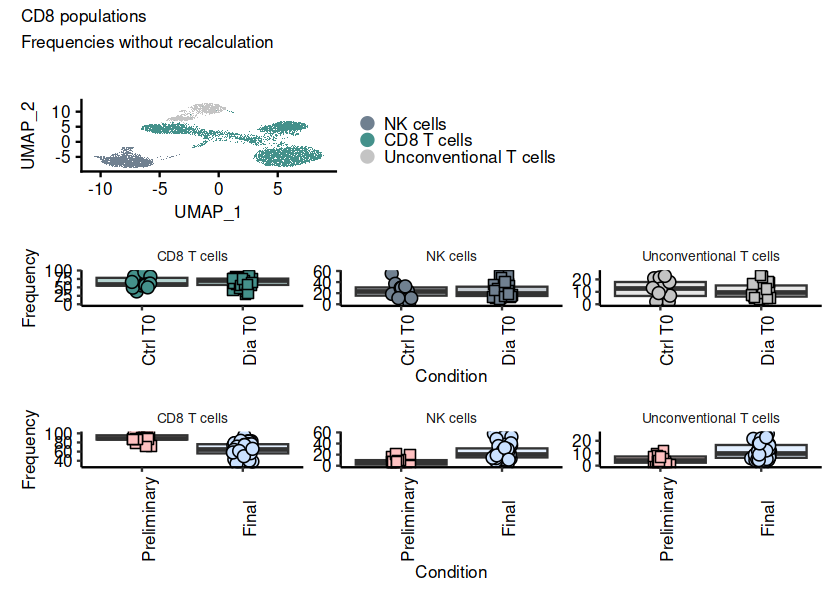

In [53]:
p3  <- dimplot1+p1+p2 + plot_layout(design = layout) + 
plot_annotation(title = "CD4 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p3

In [54]:
ggsave(filename="02_Main_populations_CD4.pdf", 
       plot = p3, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


# Coefficient of enrichment for populations in a patient

In [55]:
patients_with_preliminary  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
                                  filter(Exp == "Preliminary")  %>% pull(Patient_ID)  %>% unique

In [56]:
patients_with_preliminary

[1] "201" "202" "105" "110" "104" "106" "108" "111" "204" "208" "209" "210"
[13] "107" "113" "114" "121" "126" "127"

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


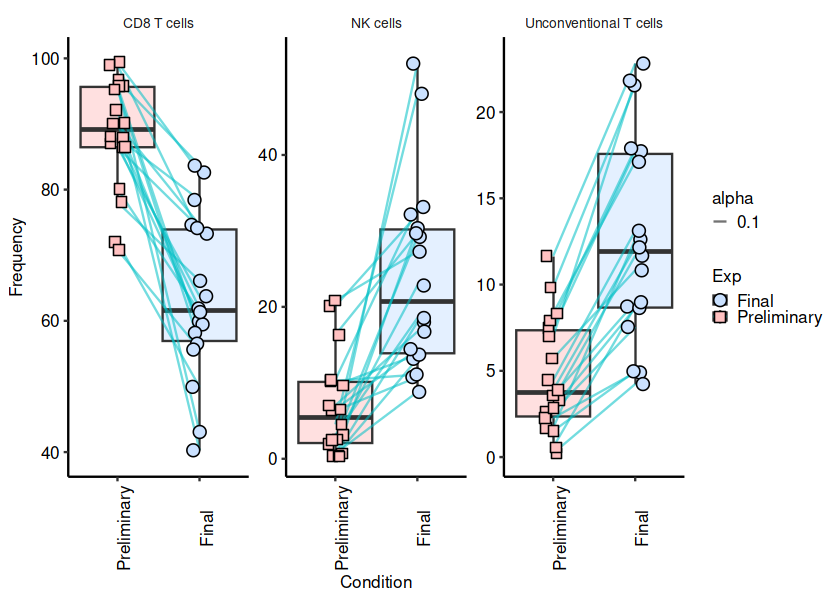

In [57]:
plot_paired  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_line(aes(group = Patient_ID, color = Exp, alpha = 0.1)) +
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
plot_paired

In [58]:
df5  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
mutate(clusters_change = paste0(Exp, annotations_l1))  %>% 
dplyr::select(Patient_ID, clusters_change, freq)  %>% 
pivot_wider(names_from = "clusters_change", values_from = freq, values_fill = 0) 

df5

Patient_ID,PreliminaryNK cells,PreliminaryCD8 T cells,PreliminaryUnconventional T cells,FinalNK cells,FinalCD8 T cells,FinalUnconventional T cells
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201,0.031212485,0.8703481,0.098439376,0.18534483,0.5991379,0.21551724
202,0.025270758,0.9578821,0.016847172,0.29212532,0.5817104,0.12616427
105,0.003314917,0.9944751,0.002209945,0.13161376,0.8260582,0.04232804
110,0.006825939,0.9670080,0.026166098,0.08801341,0.8365465,0.07544007
104,0.019417476,0.9579288,0.022653722,0.52030651,0.4306513,0.04904215
106,0.004550626,0.9897611,0.005688282,0.17983446,0.7328819,0.08728367
108,0.045287638,0.9216646,0.033047736,0.48054755,0.4027378,0.11671470
111,0.024564995,0.9007165,0.074718526,0.22813990,0.5945946,0.17726550
204,0.003072197,0.9523810,0.044546851,0.30363036,0.5651815,0.13118812


In [59]:
df_all = df5  %>% dplyr::select(Patient_ID)

for(i in 2:(1+((ncol(df5)-1)/2))){
    df = df5  %>% dplyr::select(i,i+3)
    colnames(df) = c("x","y")
    df = df  %>% mutate(z = round(x, digits = 4)/(round(y, digits = 4)+0.00001))
    df_all = cbind(df_all, df$z)
    colnames(df_all)[i]  <- str_replace(colnames(df5)[i],pattern = "Preliminary", "Final ")
}

df_all

Patient_ID,Final NK cells,Final CD8 T cells,Final Unconventional T cells
<chr>,<dbl>,<dbl>,<dbl>
201,0.16836652,1.452655,0.45659134
202,0.08661121,1.646697,0.13311148
105,0.02507408,1.203835,0.05199716
110,0.07726395,1.155993,0.34743403
104,0.03728546,2.224002,0.46317078
106,0.02558256,1.350507,0.06528462
108,0.09427483,2.288744,0.28275212
111,0.10784271,1.514774,0.42129604
204,0.01021047,1.685037,0.33915098


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


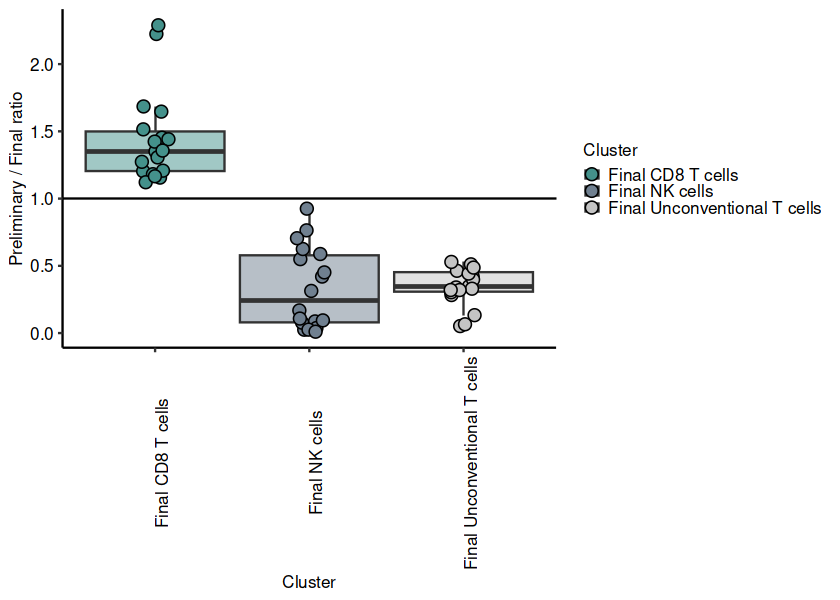

In [60]:
plot_cluster_correction  <-  df_all %>% pivot_longer(!Patient_ID, names_to = "Cluster", values_to = "Prelim_to_Final_ratio", values_drop_na = T)  %>% 
ggplot(aes(x = Cluster, y = Prelim_to_Final_ratio)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Cluster)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Cluster), shape = 21) + 
scale_fill_manual(values = cd4_full_filt@misc$colors_annotations_l1[c(2,1,3)]) +
  geom_hline(yintercept = 1) +
  ylab("Preliminary / Final ratio") +
  xlab("Cluster") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))

plot_cluster_correction

### Corrected cell frequencies

In [61]:
### V1

In [62]:
coef  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>%
group_by(annotations_l1, Exp)  %>% 
summarize(med = median(freq))  %>% 
pivot_wider(names_from = "Exp", values_from = "med")  %>% 
mutate(coefficient = round(Preliminary, digits = 4)/(round(Final, digits = 4)+0.00001))
coef

`summarise()` has grouped output by 'annotations_l1'. You can override using
the `.groups` argument.


annotations_l1,Final,Preliminary,coefficient
<chr>,<dbl>,<dbl>,<dbl>
CD8 T cells,0.6160666,0.89086815,1.4460080
NK cells,0.2067424,0.05426775,0.2626869
Unconventional T cells,0.1191332,0.03731519,0.3131559


In [63]:
df5  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
left_join(dplyr::select(coef, annotations_l1, coefficient))  %>% 
mutate(freq_corrected = freq*coefficient)

Joining with `by = join_by(annotations_l1)`


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


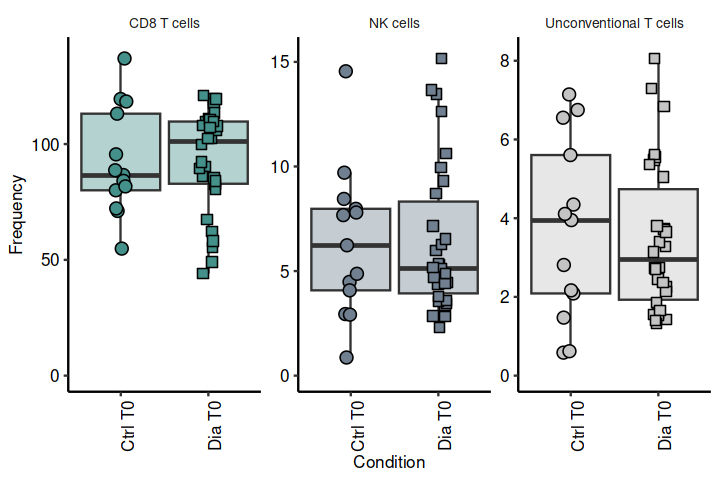

In [64]:
options(repr.plot.width = 6, repr.plot.height = 4)

p5  <- df5 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq_corrected*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l1)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l1, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("#44918b", "slategrey", "grey77"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p5

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


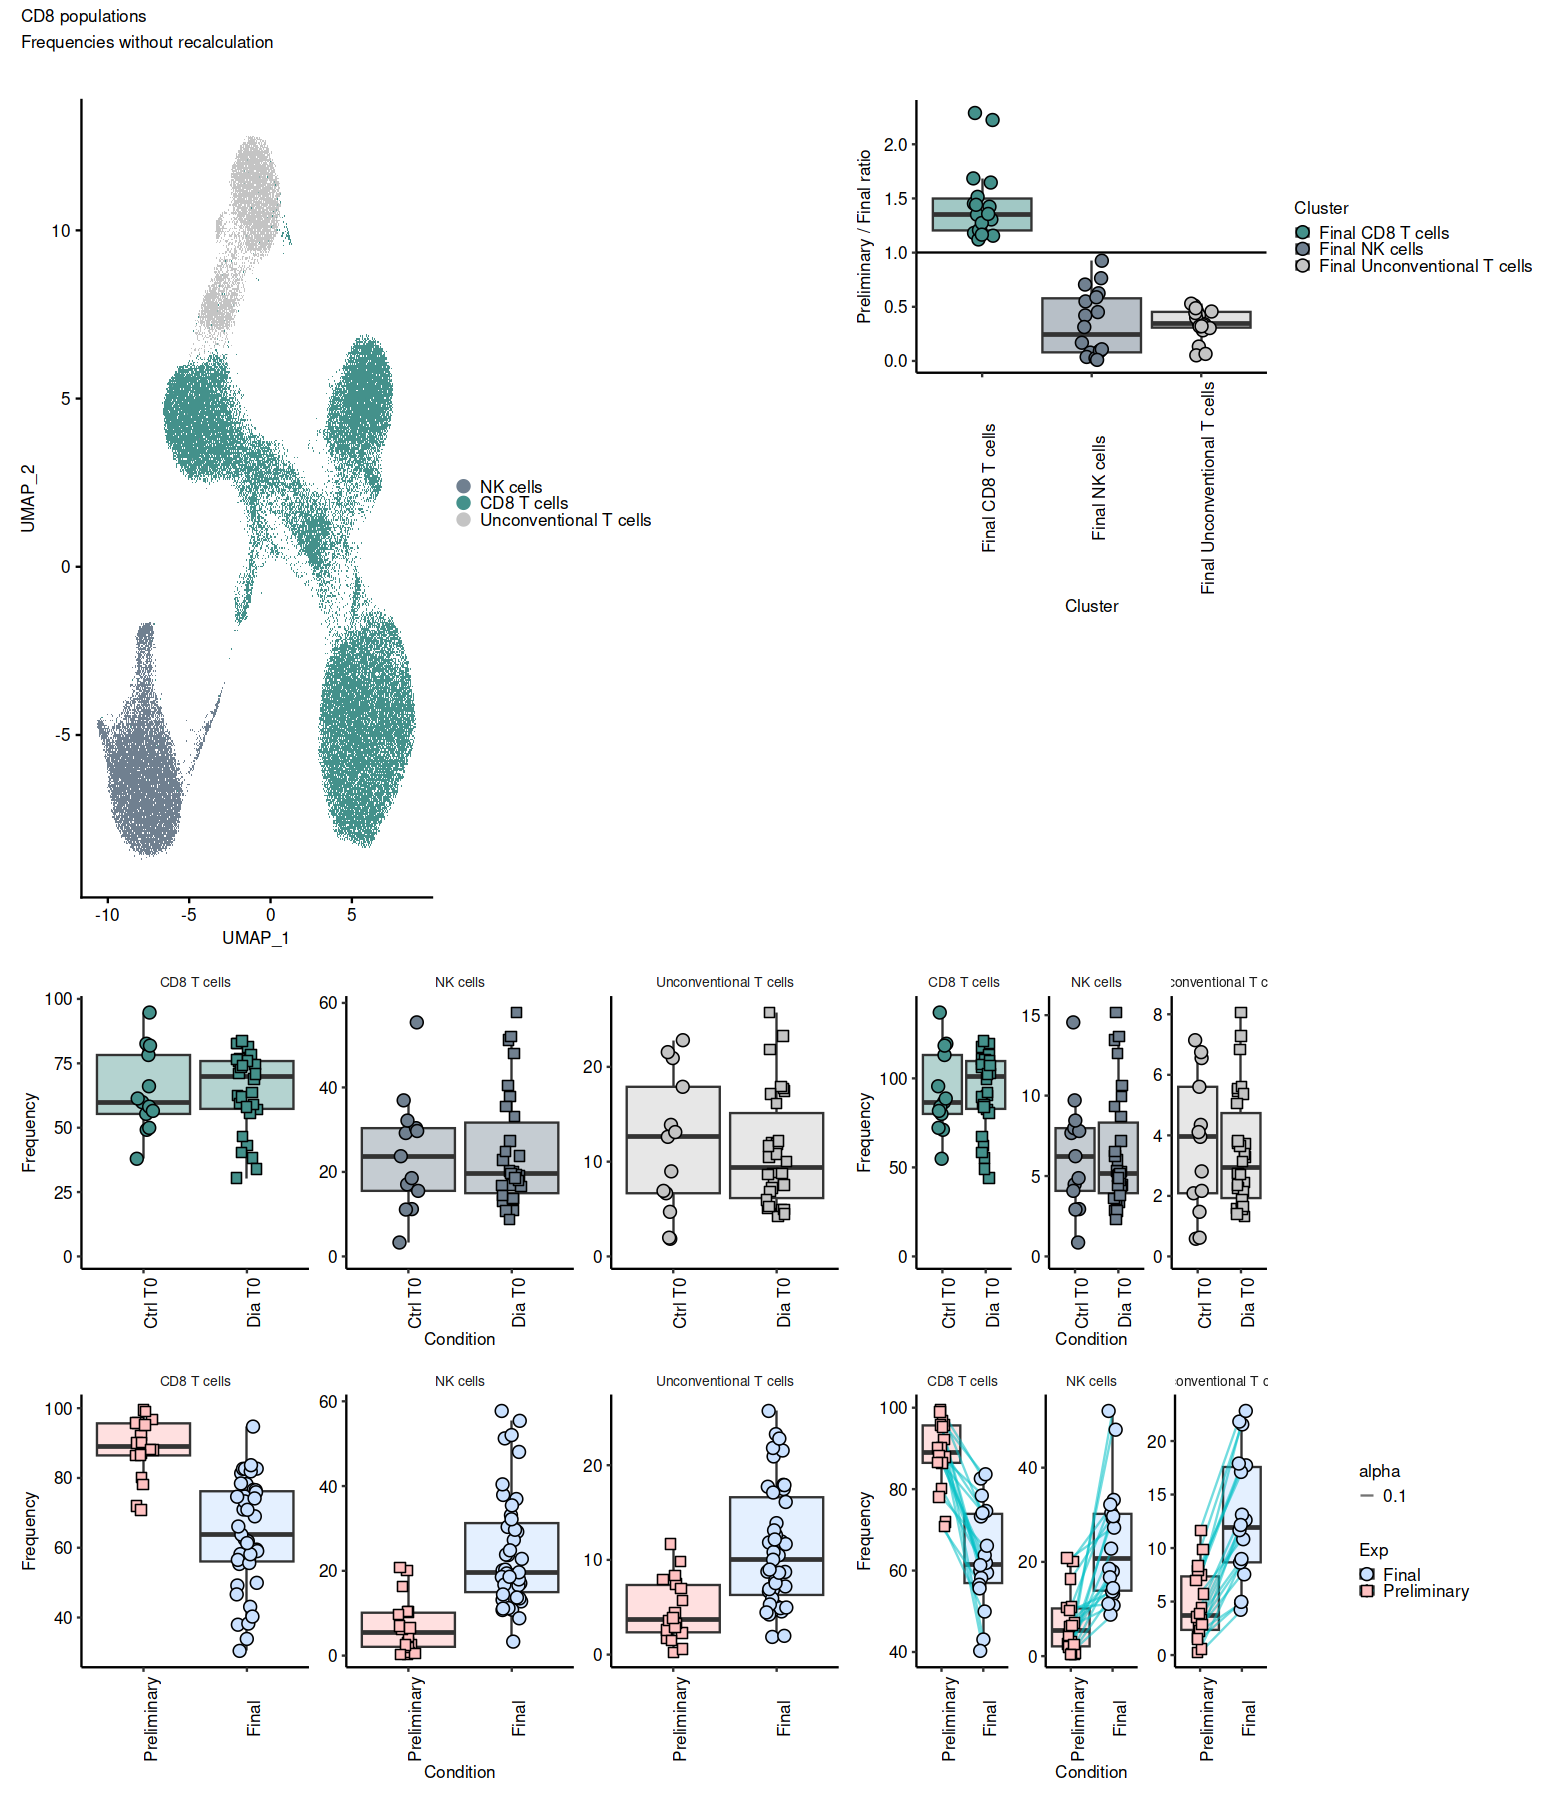

In [100]:
options(repr.plot.width = 13, repr.plot.height = 15)

layout <- "
AA#BB
AA###
CCCDD
EEEFF
"

p4 <- dimplot1 + plot_cluster_correction + p1 + p5 + p2 + plot_paired + plot_layout(design = layout) + 
plot_annotation(title = "CD4 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p4

In [101]:
ggsave(filename="02_Main_populations_CD4.pdf", 
       plot = p4, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


In [89]:
### V2

sort ratios in these patients

# CD4 subcluster 

## Cluster composition

In [27]:
cd4_subcluster@misc$cols_annotations_l2  <- c(
     "#6FC4AD", # Tcm2 
     "#92c0df", #Naive
     "#24693d", # TEM ISAGhi
     "#75bc69",  # Tem
     "#b3e0a6" , # Tcm1
     "#88aa00" , # Proliferating
     "#499894", # Temra 
     "#4878a6")

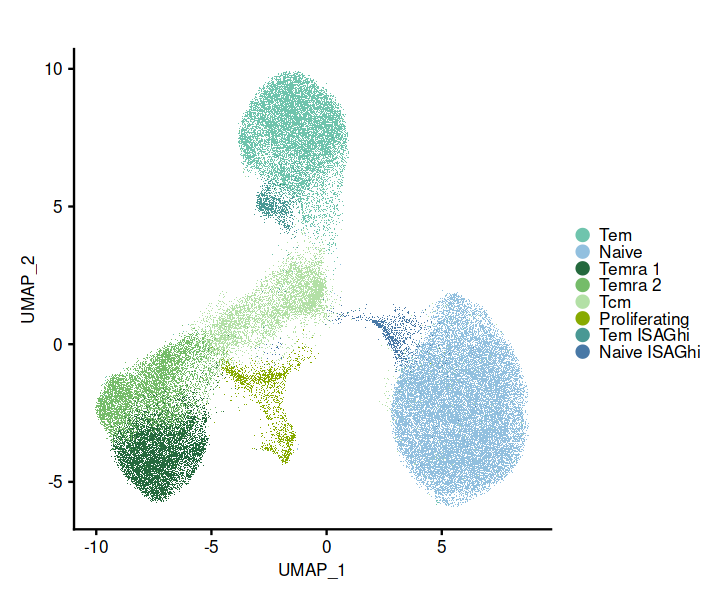

In [28]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd4_subcluster, label = F, raster = T, group.by = "annotations_l2",
       cols = cd4_subcluster@misc$cols_annotations_l2) + ggtheme() + ggtitle("")
dimplot1

In [29]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd4_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l2) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l2", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l2")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


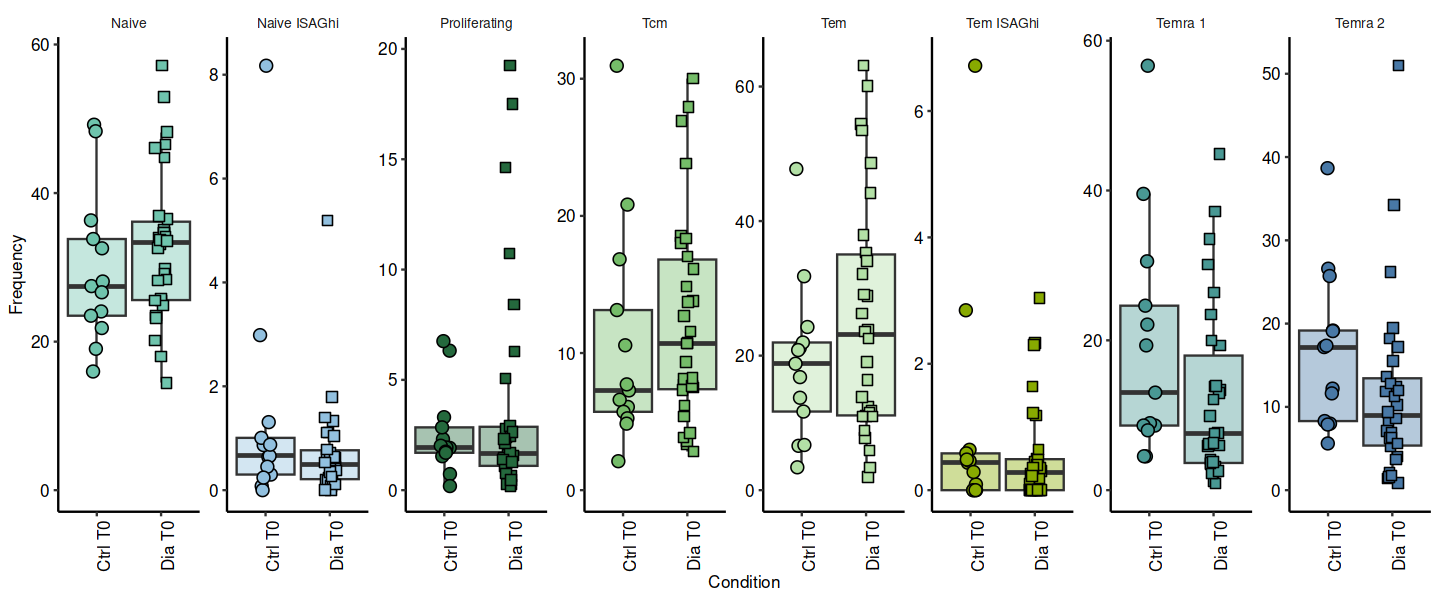

In [30]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l2)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l2, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd4_subcluster@misc$cols_annotations_l2)+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


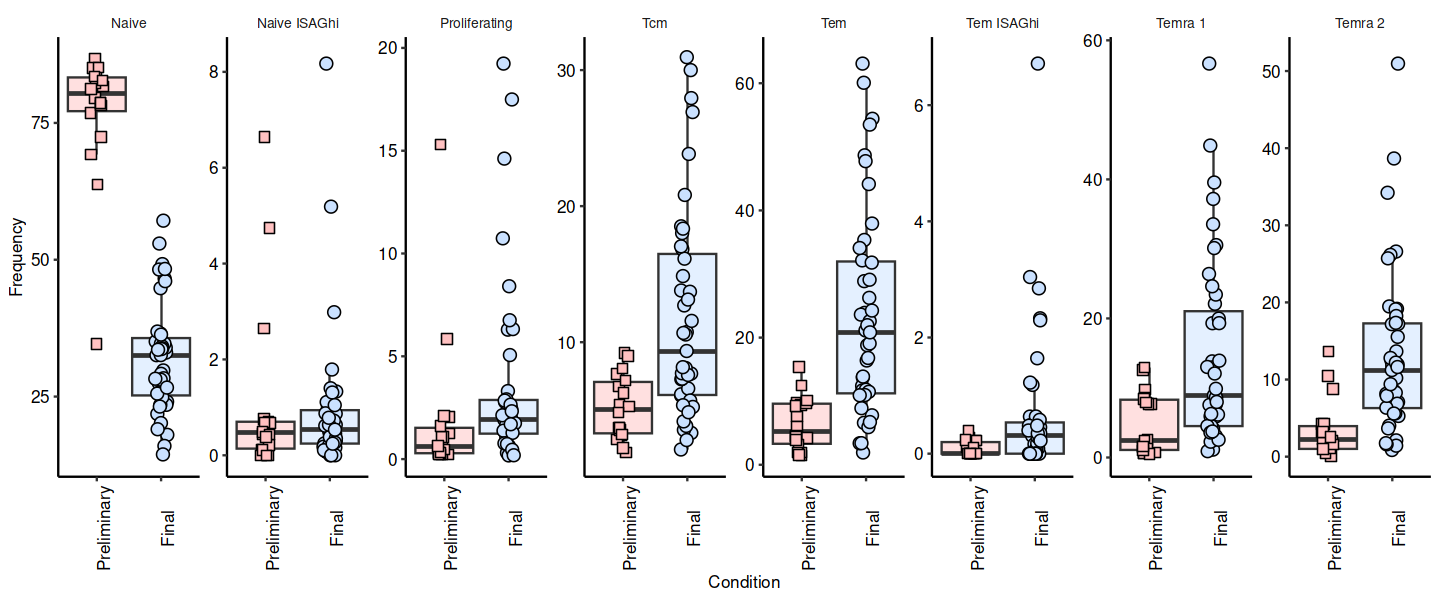

In [31]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2